In [1]:
!aws s3 sync s3://rowerki ./data

Completed 157.3 KiB/157.3 KiB (211.0 KiB/s) with 1 file(s) remaining
download: s3://rowerki/1653231293.csv to data\1653231293.csv        


In [10]:
import os
import requests 
import pandas as pd 
import matplotlib.pyplot as plt 
import utils
from datetime import datetime

In [3]:
stations = utils.get_stations()
stations.sort_values("bike_racks")

,uid,lat,lng,name,bike_racks,place_type
329,2681635,52.234390,20.999159,Spektrum Tower,11,0
342,18751910,52.183037,20.991542,Signum Work Station,12,0
348,55316960,52.196220,20.938810,Bolero,15,0
76,2585400,52.231450,20.988690,Prosta - Wronia,15,0
267,2586001,52.247314,21.042731,Metro Stadion Narodowy,15,0
...,...,...,...,...,...,...
201,2585885,52.157289,21.044008,Rosoła - Ciszewskiego - SGGW,30,0
207,2585901,52.142720,21.038362,Pileckiego - Alternatywy,30,0
60,2585369,52.244947,21.001294,Andersa - Długa,30,0
311,4393742,52.239409,21.031010,Metro Centrum Nauki Kopernik,30,0


In [4]:
bikes = utils.read_bikes()
bikes

,index,date,station_id,bike_number,bike_type,state,day
0,0,2022-04-24 17:18:00,2585259,24927,174,ok,2022-04-24
1,1,2022-04-24 17:18:00,2585259,24801,174,ok,2022-04-24
2,2,2022-04-24 17:18:00,2585259,24655,174,ok,2022-04-24
3,3,2022-04-24 17:18:00,2585259,24648,174,ok,2022-04-24
4,4,2022-04-24 17:18:00,2585259,27559,174,ok,2022-04-24
...,...,...,...,...,...,...,...
11474292,4252,2022-05-22 14:54:00,52488396,97046,174,ok,2022-05-22
11474293,4253,2022-05-22 14:54:00,52488396,75384,174,ok,2022-05-22
11474294,4254,2022-05-22 14:54:00,55316960,28653,174,ok,2022-05-22
11474295,4255,2022-05-22 14:54:00,55316960,27448,174,ok,2022-05-22


In [5]:
bikes['prev_station'] = bikes\
.sort_values(by=['date'], kind='stable')\
.groupby(['bike_number'])\
.shift(1)['station_id'].astype('Int64')
bikes['next_station'] = bikes\
.sort_values(by=['date'], kind='stable')\
.groupby(['bike_number'])\
.shift(-1)['station_id'].astype('Int64')
# You can't do next != current because it does not detect loops
bikes['just_returned'] = bikes\
.sort_values(by=['date'], kind='stable')\
.groupby(['bike_number', 'station_id'])\
.shift(1)['date'].isna() | (bikes['prev_station'] != bikes['station_id'])
bikes['just_rented'] = bikes\
.sort_values(by=['date'], kind='stable')\
.groupby(['bike_number', 'station_id'])\
.shift(-1)['date'].isna() | (bikes['next_station'] != bikes['station_id'])
bikes[bikes['bike_number'] == 96033].sort_values(by=['date'], kind='stable')

,index,date,station_id,bike_number,bike_type,state,day,prev_station,next_station,just_returned,just_rented
8782,1198,2022-04-24 15:44:00,2585470,96033,174,ok,2022-04-24,<NA>,2585470,True,False
12608,1201,2022-04-24 15:44:00,2585470,96033,174,ok,2022-04-24,2585470,2585470,False,False
16435,1201,2022-04-24 15:51:00,2585470,96033,174,ok,2022-04-24,2585470,2585470,False,False
20295,1241,2022-04-24 16:21:00,2585470,96033,174,ok,2022-04-24,2585470,2585470,False,False
24302,1335,2022-04-24 16:51:00,2585470,96033,174,ok,2022-04-24,2585470,2585470,False,False
...,...,...,...,...,...,...,...,...,...,...,...
11453155,129,2022-05-22 14:14:00,2585280,96033,174,ok,2022-05-22,2585280,2585280,False,False
11457400,126,2022-05-22 14:24:00,2585280,96033,174,ok,2022-05-22,2585280,2585280,False,False
11461656,137,2022-05-22 14:34:00,2585280,96033,174,ok,2022-05-22,2585280,2585280,False,False
11465928,138,2022-05-22 14:44:00,2585280,96033,174,ok,2022-05-22,2585280,2585280,False,False


In [6]:
grouped = bikes\
.groupby(['date', 'station_id'])\
.aggregate({'bike_number' : len, 'just_returned' : sum,'just_rented' : sum})\
.reset_index()\
.rename(columns={'bike_number': 'bike_count'})\
.merge(stations,left_on = 'station_id', right_on = 'uid')
grouped['just_rented'] = grouped.sort_values(['date']).groupby('station_id').shift(1)['just_rented']
grouped

,date,station_id,bike_count,just_returned,just_rented,uid,lat,lng,name,bike_racks,place_type
0,2022-04-24 15:44:00,448565,6,3,NaN,448565,52.183992,21.009840,Nestle House,15,0
1,2022-04-24 15:51:00,448565,4,1,0.0,448565,52.183992,21.009840,Nestle House,15,0
2,2022-04-24 16:21:00,448565,1,0,3.0,448565,52.183992,21.009840,Nestle House,15,0
3,2022-04-24 16:51:00,448565,5,4,0.0,448565,52.183992,21.009840,Nestle House,15,0
4,2022-04-24 17:21:00,448565,7,6,4.0,448565,52.183992,21.009840,Nestle House,15,0
...,...,...,...,...,...,...,...,...,...,...,...
901956,2022-05-22 14:14:00,2585788,23,3,1.0,2585788,52.204264,21.014428,Madalińskiego - Kazimierzowska,24,0
901957,2022-05-22 14:24:00,2585788,20,0,3.0,2585788,52.204264,21.014428,Madalińskiego - Kazimierzowska,24,0
901958,2022-05-22 14:34:00,2585788,20,0,0.0,2585788,52.204264,21.014428,Madalińskiego - Kazimierzowska,24,0
901959,2022-05-22 14:44:00,2585788,20,0,0.0,2585788,52.204264,21.014428,Madalińskiego - Kazimierzowska,24,0


In [7]:
grouped = utils.rented_returned_amount(bikes)

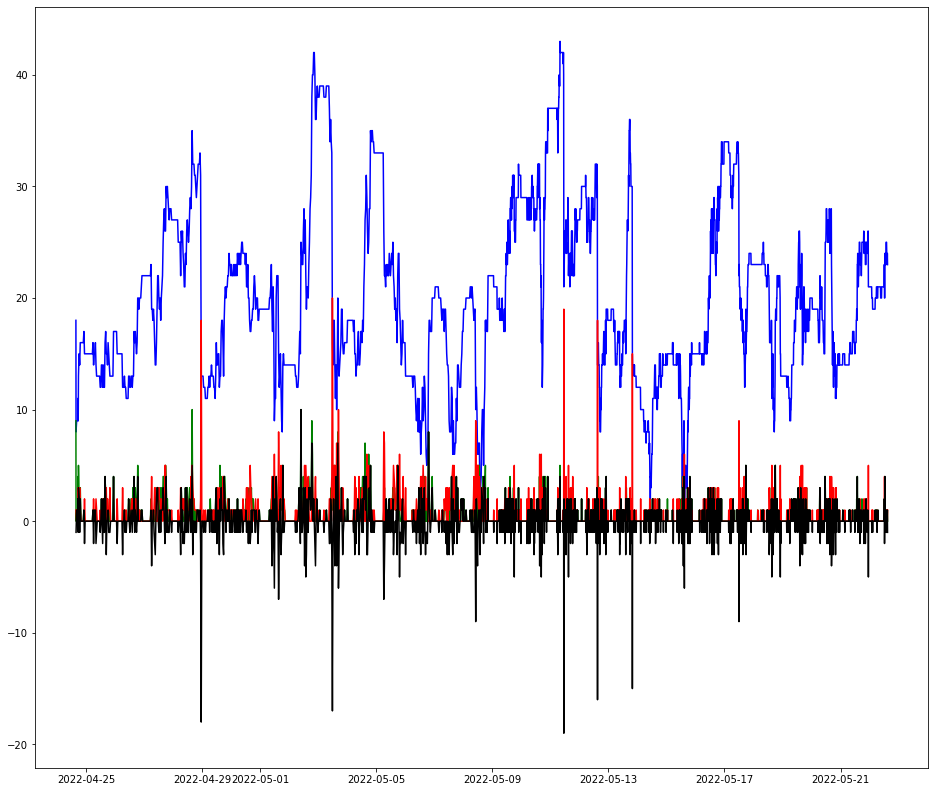

In [8]:
df = grouped[grouped['name'] == "Metro Stokłosy"]
plt.figure(figsize=(16,14))
for col, y in [("blue", "bike_count"), ("green", 'just_returned'), ("red", 'just_rented')]:
    plt.plot(df["date"], df[y], c=col)
plt.plot(df["date"], df['just_returned'] - df['just_rented'], c='black')

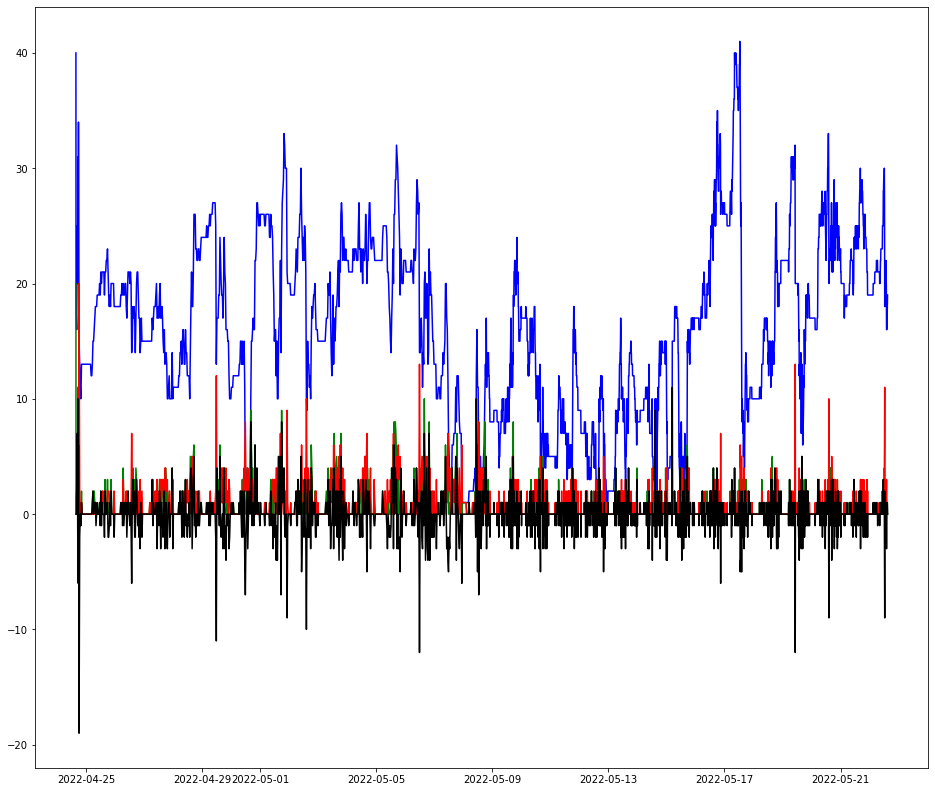

In [9]:
df = grouped[grouped['name'] == "Metro Imielin"]
plt.figure(figsize=(16,14))
for col, y in [("blue", "bike_count"), ("green", 'just_returned'), ("red", 'just_rented')]:
    plt.plot(df["date"], df[y], c=col)
plt.plot(df["date"], df['just_returned'] - df['just_rented'], c='black')